# Use NN trained on CTCF in RPTECs to predict impact of significant variants in Wuttke et al 2019

## Get significant variants from Wuttke

Download variants in gzipped file from https://ckdgen.imbi.uni-freiburg.de/ then fed through python to make vcf for selene and flip to hg38

```sh
wget https://ckdgen.imbi.uni-freiburg.de/files/Wuttke2019/20171016_MW_eGFR_overall_ALL_nstud61.dbgap.txt.gz
```



### Pull in public GWAS results, filter, and flip to hg38 vcf for prediction

In [ ]:
import math
from pyliftover import LiftOver

#Iterate over downloaded and unzipped tsv GWAS output, filter by p-value, flip to hg38, and output as "vcf" w/ out header for selen
p_thresh = 1e-8
gwas_tsv_in = "/input_dir/ml_testing/kidney_test/gwas_out/20171016_MW_eGFR_overall_ALL_nstud61.dbgap.txt"
vcf_out_name = "/input_dir/ml_testing/kidney_test/gwas_out/Wuttke_eGFR_"+str(p_thresh)+"_hg38.vcf"
bed_out_name = "/input_dir/ml_testing/kidney_test/gwas_out/Wuttke_eGFR_"+str(p_thresh)+"_hg38.bed"
flip_genome = True

#Input header
# Chr Pos_b37 RSID Allele1 Allele2 Freq1 Effect StdErr P-value n_total_sum

#Output vcf format:
# chr1    783547  783547  A       G
if (flip_genome):
    lo = LiftOver("hg19", "hg38")

with open(bed_out_name, "w") as bed_out:
    with open(vcf_out_name, "w") as vcf_out:
        with open(gwas_tsv_in, "r") as gwas_in:
            header = gwas_in.readline().strip().split("\t")
            for loci in gwas_in.readlines():
                loci_arr = loci.strip().split()
                if float(loci_arr[8]) <= p_thresh:
                    cur_loc = loci_arr[1]
                    if (flip_genome):
                        lift_out = lo.convert_coordinate("chr"+loci_arr[0],int(cur_loc))
                        if (lift_out is not None) and len(lift_out)>0:
                            cur_loc = lift_out[0][1]
                            vcf_out_line = "chr" + loci_arr[0] + "\t" + str(cur_loc) + "\t" + str(cur_loc) + "\t" + loci_arr[3].upper() + "\t" + loci_arr[4].upper() + "\n"
                            vcf_out.write(vcf_out_line)
                            bed_out_line = "chr" + loci_arr[0] + "\t" + str(cur_loc) + "\t" + str(cur_loc+1) + "\t" + loci_arr[2] + ":" + loci_arr[3].upper() + ":" + loci_arr[4].upper() + "\t" + str(round(-math.log10(float(loci_arr[8])),2)) + "\n"
                            bed_out.write(bed_out_line)
                        else:
                            print("variant " + str(loci_arr[0]) + ":" + str(loci_arr[1]) + " not found when liftover, skipping")


## Use trained NN to predict VCFs

### Yaml file for using NN to predict VCFs

```YAML
ops: [analyze]
model: {
    path: /input_dir/ml_testing/kidney_test/deeperdeepsea.py,
    class: DeeperDeepSEA,
    class_args: {
        sequence_length: 1000,
        n_targets: 1,
    },
    non_strand_specific: mean
}
analyze_sequences: !obj:selene_sdk.predict.AnalyzeSequences {
    trained_model_path:/input_dir/ml_testing/kidney_test/training_outputs/best_model.pth.tar,
    sequence_length: 1000,
    features: !obj:selene_sdk.utils.load_features_list {
        input_path: /input_dir/ml_testing/kidney_test/distinct_features.txt
    },
    batch_size: 64,
    use_cuda: True,
    reference_sequence: !obj:selene_sdk.sequences.Genome {
        input_path: /input_dir/ml_testing/genomic_annotations/hg38.fa
    },
    write_mem_limit: 75000
}
variant_effect_prediction: {
    vcf_files: [
        /input_dir/ml_testing/kidney_test/gwas_out/Wuttke_eGFR_1e8_hg19.vcf
    ],
    save_data: [logits],
    output_dir: /input_dir/ml_testing/kidney_test/prediction_outputs,
    output_format: tsv,
    strand_index: 9
}
random_seed: 123
```

In [ ]:
%matplotlib inline

from selene_sdk.utils import load_path
from selene_sdk.utils import parse_configs_and_run
from selene_sdk.interpret import load_variant_abs_diff_scores

In [ ]:
configs = load_path("./CTCF_kidney_predict.yml")

In [ ]:
parse_configs_and_run(configs, lr=0.01)

# Visualize output of NN predictions

In [10]:
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px


def gen_chrom_col(in_chroms):
    col_map = px.colors.sequential.Rainbow * 3
    chroms = ["chr" + str(x) for x in range(1,23)]
    chroms = chroms + ["chrX","chrY"]
    chrom_rainbow = {chroms[i]: col_map[i] for i in range(len(chroms))} 
    mapped_cols = [chrom_rainbow[x] for x in in_chroms]
    return(mapped_cols)

out_var_scores = pd.read_table("/input_dir/ml_testing/kidney_test/prediction_outputs/Wuttke_eGFR_1e-08_hg38_abs_diffs.tsv")
var_label = out_var_scores.apply (lambda row: row["chrom"] + ":" + str(row["pos"]) + ":" + row["ref"] + ":" + row["alt"], axis=1)
data_var = { 'variant_labels' : var_label, 
            'abs_diffs' : out_var_scores["RPTEC|CTCF|None"], 
            'chromosome' : out_var_scores["chrom"], 
            'locations' : out_var_scores["pos"]}

df_var = pd.DataFrame(data_var)
df_var_filt = df_var[df_var["abs_diffs"]>.001]



In [11]:
#Make bed files for abs diff
df_var_filt_hard = df_var[df_var["abs_diffs"]>.01]
bed_out_diff = "/input_dir/ml_testing/kidney_test/prediction_outputs/Wuttke_eGFR_1e-08_hg38_abs_diffs_filt.bed"

with open(bed_out_diff,"w") as bed_out:
    for index, row in df_var_filt_hard.iterrows():
        b = (row["chromosome"] + 
             "\t" + str(row["locations"]) + 
             "\t" + str(row["locations"]+1) + 
             "\t" + row["variant_labels"] + 
             "\t" + str(abs(row["abs_diffs"])) + "\n")
        bed_out.write(b)

In [12]:

xaxis=dict(
    showline=False,
    zeroline=False,
    showgrid=False,
    showticklabels=False,
    showbackground=False,
    titlefont=dict(size=20),
    ticks = ''
    )

yaxis=dict(
    showline=False,
    zeroline=False,
    showgrid=False,
    showticklabels=False,
    showbackground=False,
    titlefont=dict(size=20),
    ticks = '')

layout = dict(
    scene= dict(
                xaxis=xaxis,
                yaxis=yaxis), 
    title=dict(y=.95,
              x=.5,
              font=dict(size=30)),
    width = 1280,
    height = 860,
    showlegend=False
)

data = [dict(
    type = 'scatter',
    mode = 'markers',
    y = df_var_filt['abs_diffs'],
    text = df_var_filt['variant_labels'],
    hoverinfo = 'text',
    opacity = 0.8,
    marker = dict(size=8, color = gen_chrom_col(df_var_filt["chromosome"]), line=dict(color='DarkGrey',width=1))
)]
fig = dict({'data' : data, 'layout' : layout})
fig_out = go.Figure(fig)
fig_out.update_layout(title_text="Significant eGFR GWAS SNP's impact on CTCF NN activation",
                      xaxis_showticklabels=False,
                      xaxis_title="Genomic location", 
                      yaxis_title = "Absolute difference in NN activation")
fig_out.update_layout(template="plotly_white+xgridoff")

pio.write_html(fig_out, file= "CTCF_eGFR_vars.html", auto_open=False)

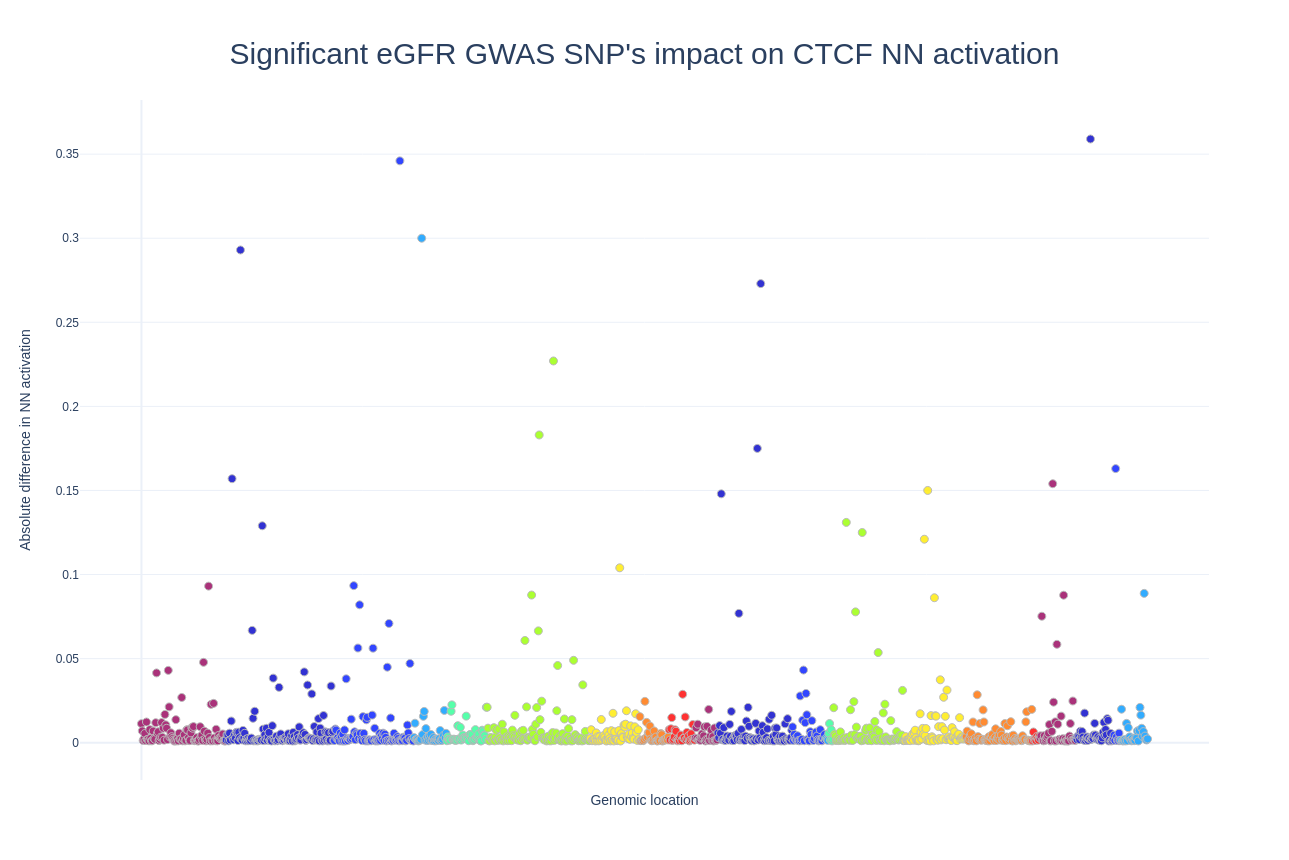

In [13]:
fig_out.show()

In [14]:
##Repeat for logit scores
out_var_logit = pd.read_table("/input_dir/ml_testing/kidney_test/prediction_outputs/Wuttke_eGFR_1e-08_hg38_logits.tsv")
var_label = out_var_logit.apply (lambda row: row["chrom"] + ":" + str(row["pos"]) + ":" + row["ref"] + ":" + row["alt"], axis=1)
data_var = { 'variant_labels' : var_label, 
            'logit' : out_var_logit["RPTEC|CTCF|None"], 
            'chromosome' : out_var_logit["chrom"], 
            'locations' : out_var_logit["pos"]}

df_var = pd.DataFrame(data_var)
df_var_filt = df_var[abs(df_var["logit"])>.1]

In [15]:
#Make bed files for logit
df_var_filt_hard = df_var[abs(df_var["logit"])>1]
bed_out_logit = "/input_dir/ml_testing/kidney_test/prediction_outputs/Wuttke_eGFR_1e-08_hg38_logit_filt.bed"

with open(bed_out_logit,"w") as bed_out:
    for index, row in df_var_filt_hard.iterrows():
        b = (row["chromosome"] + 
             "\t" + str(row["locations"]) + 
             "\t" + str(row["locations"]+1) + 
             "\t" + row["variant_labels"] + 
             "\t" + str(abs(row["logit"])) + "\n")
        bed_out.write(b)

In [16]:
data = [dict(
    type = 'scatter',
    mode = 'markers',
    y = df_var_filt['logit'],
    text = df_var_filt['variant_labels'],
    hoverinfo = 'text',
    opacity = 0.8,
    marker = dict(size=8, color = gen_chrom_col(df_var_filt["chromosome"]), line=dict(color='DarkGrey',width=1))
)]
fig = dict({'data' : data, 'layout' : layout})
fig_out = go.Figure(fig)
fig_out.update_layout(title_text="Significant eGFR GWAS SNP's impact on CTCF NN logit score",
                      xaxis_showticklabels=False,
                      xaxis_title="Genomic location", 
                      yaxis_title = "Logit score in NN activation")
fig_out.update_layout(template="plotly_white+xgridoff")

pio.write_html(fig_out, file= "CTCF_eGFR_vars_logit.html", auto_open=False)


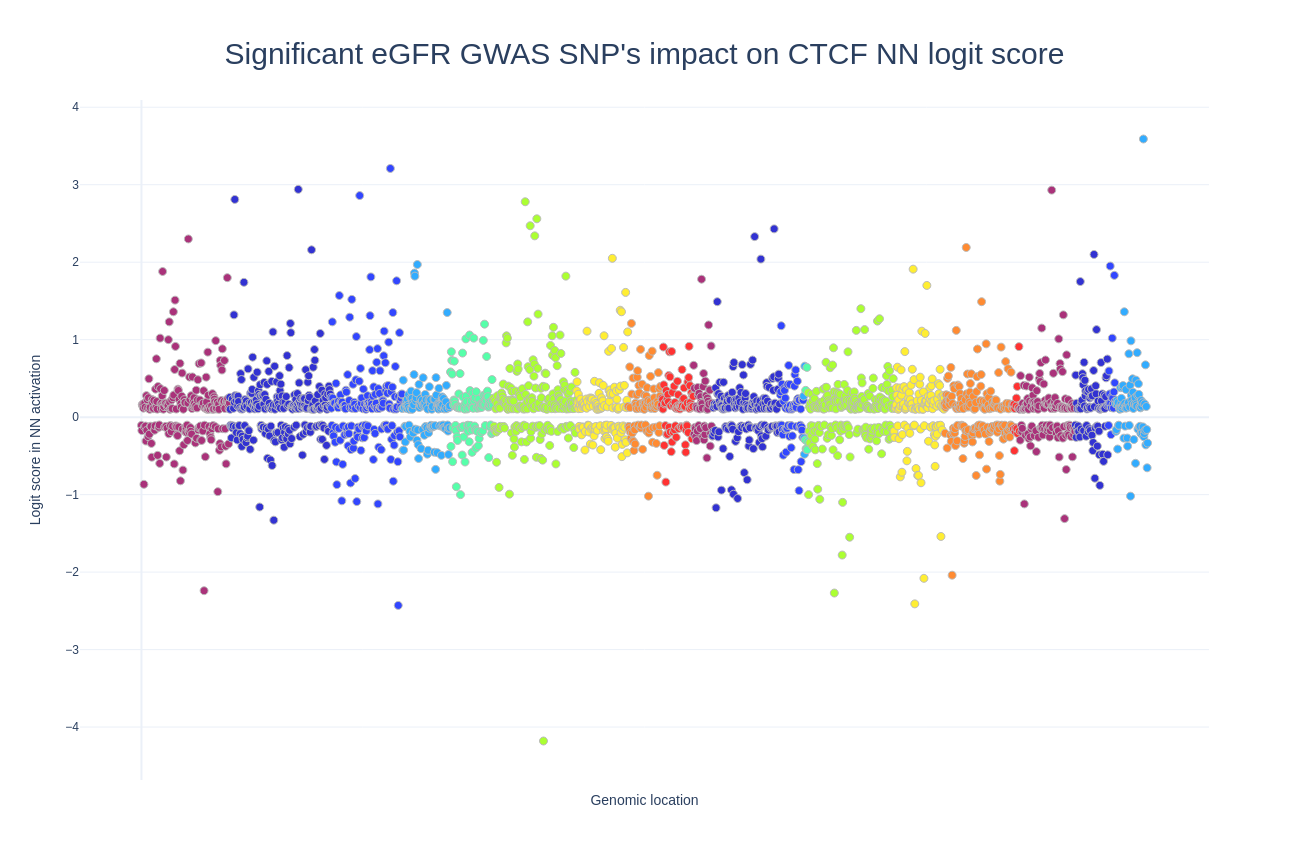

In [17]:
fig_out.show()
